## Abstract: This notebook will be used for the capstone project


In [73]:
# Load libraries
import os
import numpy as np
from scipy.stats import mode
import io


import pandas as pd
import shutil
from PIL import Image


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder


In [74]:
class FileWriter:
    def __init__(self, filename):
        self.filename = filename

    def __enter__(self):
        self.file = open(self.filename, 'a')
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.file.close()

    def append_to_file(self, text):
        self.file.write(text + '\n')

In [75]:

class ImageProcessor:
    def __init__(self, csv_file, corrupt_dir, output_csv):
        self.df = pd.read_csv(csv_file)
        self.corrupt_dir = corrupt_dir
        self.output_csv = output_csv

    def is_corrupt(self, file_path):
        try:
            Image.open(file_path)
        except IOError:
            return True
        return False

    def process_image(self, file_path, size=(100, 100)):
        try:
            img = Image.open(file_path)
            img = img.resize(size)  # Resize image
            img = img / 255.0  # Standardize intensity to range [0, 1]
            img.save(file_path)
        except IOError:
            print(f"Error processing image {file_path}")
            return False
        return True

    def process_images(self):
        for index, row in self.df.iterrows():
            file_path = row['image_path']
            if self.is_corrupt(file_path):
                shutil.move(file_path, self.corrupt_dir)  # Move corrupt files to a separate directory
                self.df.drop(index, inplace=True)  # Remove the row from the DataFrame
            else:
                if not self.process_image(file_path):
                    self.df.drop(index, inplace=True)  # If there was an error processing the image, remove the row
        self.df.to_csv(self.output_csv, index=False)  # Save the updated DataFrame to a new CSV file


In [76]:
class DF_Comparison:
    def __init__(self, df1, df2):
        self.df1 = df1
        self.df2 = df2
        self.outfutfile = "output.md"

       
    def report(self):

        with open(self.outfutfile , 'w'):
             pass

        self.print_info(self.df1,"\n ## DataFrame info befor process :")
        self.print_Missing_values(self.df1,"\n ## Missing values befor & aftre  process :")
             
        # print("\nUnique values df1 - df2:")
        title = "\n ## Unique values befor & aftre  process :"
        self.print_unique_values(title)

        self.print_value_count("\n ## Value counts befor & aftre  process :")
        title = "\n ## Descriptive statistics befor and after the process:"



        # Getting the description of both DataFrames
        desc_df1 = self.df1.describe()
        desc_df2 = self.df2.describe()

        # Combine the two descriptions into one DataFrame
        combined_desc = pd.concat([desc_df1, desc_df2], axis=1)

        markdown_str = combined_desc.to_markdown()

        with FileWriter(self.outfutfile ) as writer:
            writer.append_to_file(title)
            writer.append_to_file(markdown_str)
            writer.append_to_file('\n')

      

        
    def print_info(self,df,title):

        
        # Capture df.info() output in a string
        buf = io.StringIO()
        df.info(buf=buf)
        info_str = buf.getvalue()

        # Create a summary DataFrame
        info_list = info_str.split('\n')[5:-3]  # Remove first and last two lines
        info_data = [line.split() for line in info_list]  # Split each line into list of words
        # Create dataframe from info_data
        info_df = pd.DataFrame(info_data, columns=['index', 'Name', 'Count', 'Non-Null','Dtype'])

        # Print the summary DataFrame in markdown format
        # print(info_df.to_markdown(index=False))
        # print("\n")

        markdown_str = info_df.to_markdown()

        # Write the markdown string to a text file
        with FileWriter(self.outfutfile ) as writer:
            writer.append_to_file(title)
            writer.append_to_file(markdown_str)
            writer.append_to_file('\n')
    
    
    def print_Missing_values(self,df,title):

        # Get the count of null values in each column
        null_counts1 = self.df1.isnull().sum()
        null_counts2 = self.df2.isnull().sum()
        null_counts = pd.DataFrame({'Befor':null_counts1,'After':null_counts2})
        
        with FileWriter(self.outfutfile ) as writer:
             writer.append_to_file(title)
             writer.append_to_file(null_counts.to_markdown())
             writer.append_to_file('\n')

    def print_unique_values(self,title):

        unique_counts1 = self.df1.nunique()
        unique_counts2 = self.df2.nunique()
        unique_counts = pd.DataFrame({'Befor':unique_counts1,'After':unique_counts2})

        #print(unique_counts)    
        # Write the markdown string to a text file
        with FileWriter(self.outfutfile ) as writer:
             writer.append_to_file(title)
             writer.append_to_file(unique_counts.to_markdown())
             writer.append_to_file('\n')

    def print_value_count(self,title):

        # Create an empty DataFrame to store the results
        result = pd.DataFrame()
        
        # Iterate over each column
        for column in self.df1.columns:

            if self.df1[column].nunique() > 8:
                continue

            df1_counts = self.df1[column].value_counts()
            df2_counts = self.df2[column].value_counts()

            # Combine the two Series into a DataFrame
            temp_df = pd.concat([df1_counts, df2_counts], axis=1, keys=['DF1', 'DF2'])

            # Add the column name to the DataFrame
            temp_df['Column'] = column

            # Append the temporary DataFrame to the result DataFrame
            
            result = pd.concat([result, temp_df])
            

        # Reset the index of the result DataFrame
        result.reset_index(inplace=True)

        # Rename the columns for clarity
        result.columns = ['Value', 'Count Befor', 'Count After', 'Column']

        # Rearrange the columns
        result = result[['Column', 'Value', 'Count Befor', 'Count After']]

        with FileWriter(self.outfutfile ) as writer:
             writer.append_to_file(title)
             writer.append_to_file(result.to_markdown())
             writer.append_to_file('\n')

        


In [77]:
import base64



class DataCleaner:
    def __init__(self, df):
        self.df = df
        self.scaler = StandardScaler()
        self.encoder = LabelEncoder()
        self.outfutfile = "output.md"

       
    def report_and_recommend(self):
        
        title = ("\nRecommendations:")
        with FileWriter(self.outfutfile ) as writer:
            writer.append_to_file(title)
            for column in self.df.columns:
                if self.df[column].isnull().sum() > 0:
                        writer.append_to_file(f"- Column '{column}' has missing values. Consider using dropna() or fillna().")
                            

                if self.df[column].dtype == 'object':
                        writer.append_to_file("- Column '{column}' is categorical. Consider encoding it using label encoding or one-hot encoding.")


                elif self.df[column].dtype in ['int64', 'float64']:
                        writer.append_to_file(f"- Column '{column}' is numerical. Consider scaling it using standard scaling or min-max scaling.")
        
            writer.append_to_file("\nRecommendations - END -:")        
   
    def visualize(self, column):
               
            if self.df[column].dtype in ['int64', 'float64']:
                self.df[column].hist()
                plt.xlabel(column)
                plt.title(f"Histogram of {column}")
                plt.show()
                fname = f"media/Histogram of {column}.png" 
                # Save the plot as a png image
                plt.savefig(fname)
                # Markdown syntax for displaying an image
                #markdown_image_syntax = f"![Image](media\{fname})\n"
                binary_fc       = open(fname, 'rb').read()  # fc aka file_content
                base64_utf8_str = base64.b64encode(binary_fc).decode('utf-8')

                #ext     = filepath.split('.')[-1]
                # dataurl = f'data:base64,{base64_utf8_str}'
                # markdown_image_syntax = dataurl
                
                
            else:
            
                plot = sns.countplot(x=column, data=self.df)
                plt.setp(plot.get_xticklabels(), rotation=90)
                plt.title(f"Count plot of {column}")
                plt.show()

                fname = f"media/Count plot of {column}.png"
                # Save the plot as a png image
                plt.savefig(fname)
                # Markdown syntax for displaying an image
                #markdown_image_syntax = f"![Image](media\{ fname })\n"
                binary_fc       = open(fname, 'rb').read()  # fc aka file_content
                base64_utf8_str = base64.b64encode(binary_fc).decode('utf-8')

                #ext     = filepath.split('.')[-1]
               # dataurl = f'data:base64,{base64_utf8_str}'
            # markdown_image_syntax = dataurl
                
                
               

            with FileWriter(self.outfutfile ) as writer:
                writer.append_to_file(markdown_image_syntax) 
   
    def drop_missing(self):
        self.df.dropna(inplace=True)

    def fill_missing(self, column, value):
        self.df[column].fillna(value, inplace=True)

    def encode_categorical(self, column):
        self.df[column] = self.encoder.fit_transform(self.df[column])

    def scale_numerical(self, column):
        self.df[column] = self.scaler.fit_transform(self.df[column].values.reshape(-1, 1))

    def fill_missing_numeric_With_mean(self, column1, column2):
        # Calculate the mean of 'column1' for each category in 'column2'
        mean_values = self.df.groupby(column2)[column1].mean()

        # Fill the missing values in 'column1' with the mean of 'column1' in the same category in 'column2'
        self.df[column1] = self.df.apply(
             lambda row: mean_values[row[column2]] if pd.isnull(row[column1]) else row[column1],axis=1)
        
    def fill_missing_Category_values(self, column1, column2):
       
        # # Define a lambda function to compute the mode
        fill_mode = lambda x: x.fillna(x.mode().iloc[0])

        # # Fill missing values in column1 column with the mode of the corresponding group in column2
        self.df[column1] = self.df.groupby(column2)[column1].transform(fill_mode)
        
        
       


In [78]:
def Write_Readme_file():
    
    # names of the files to be concatenated
    file1 = "README _Org.md"
    file2 = "output.md"

    # name of the output file
    output_file = "README.md"

    # open the output file in write mode
    with open(output_file, "w") as outfile:
        # open the first file in read mode
        with open(file1, "r") as infile:
            # write its contents to the output file
            content = infile.read()
            # print(f"Content of {file1}:")
            # print(content)
            outfile.write(content)

        # write a newline to separate the contents of the two files
        outfile.write("\n")

        # open the second file in read mode
        with open(file2, "r") as infile:
            # write its contents to the output file
            content = infile.read()
            # print(f"Content of {file2}:")
            # print(content)
            outfile.write(content)
    outfile.close()
    

In [79]:

# # Usage
# processor = ImageProcessor('images.csv', 'corrupt_files', 'new_images.csv')
# processor.process_images()

# # Load your dataframe
# df = pd.read_csv('metadata.csv')  # replace with your actual path

# cleaner = DataCleaner(df)

# # Pre-cleaning report
# cleaner.report()

# # Handle missing values
# cleaner.drop_missing()  # or cleaner.fill_missing('column_name', value)

# # Encode categorical variables
# cleaner.encode_categorical('categorical_column')  # replace 'categorical_column' with your actual column

# # Scale numerical variables
# cleaner.scale_numerical('numerical_column')  # replace 'numerical_column' with your actual column

# # Post-cleaning report
# cleaner.report()

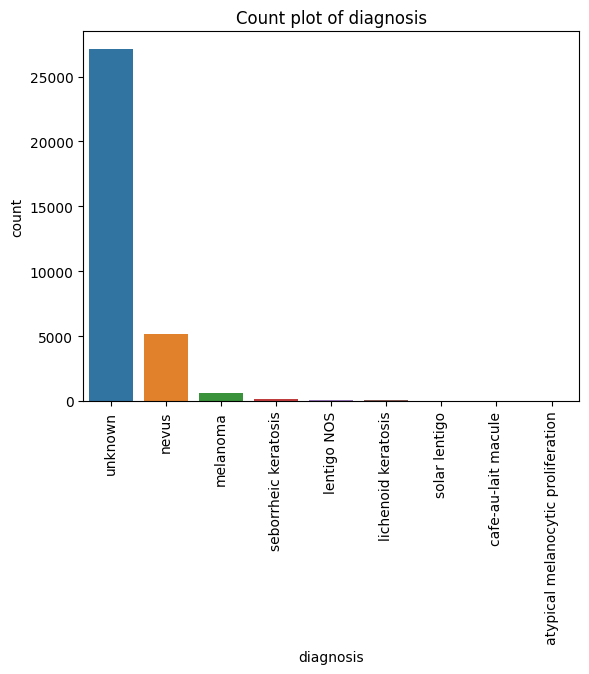

NameError: name 'markdown_image_syntax' is not defined

<Figure size 640x480 with 0 Axes>

In [80]:
# Define row CSV file name and path
File_name = 'train.csv'
Path_Name = 'Data/Row_data(pre)'
row_csv_file = os.path.join(Path_Name, File_name)

df_org  = pd.read_csv(row_csv_file)
df_org.rename(columns={"anatom_site_general_challenge": "anatomy_sites"}, inplace=True) # rename column name
df_new = df_org.copy()

DF_Comparison_1 = DF_Comparison(df_org, df_new)

cleaner_1 = DataCleaner(df_org)
cleaner_2 = DataCleaner(df_new)

cleaner_1.report_and_recommend()
cleaner_2.fill_missing_numeric_With_mean('age_approx', 'diagnosis')
cleaner_2.fill_missing_Category_values('anatomy_sites', 'diagnosis')
cleaner_2.fill_missing_Category_values('sex', 'diagnosis')
cleaner_2.report_and_recommend()

DF_Comparison_1.report()

#updated with out error

#cleaner.report()
cleaner_2.visualize('diagnosis')
cleaner_2.visualize('sex')
cleaner_2.visualize('age_approx')
cleaner_2.visualize('anatomy_sites')
cleaner_2.visualize('target')
cleaner_2.visualize('benign_malignant')

Write_Readme_file()